In [2]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from scripts.contrastive_learning_2d import ConstrativeLearningModel, SupConLoss

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = check_cuda()

Running on local machine
matplotlib settings set
CUDA is not available.
Device: cpu


# Data loaders

In [3]:
dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, 
                      load_2d=True, load_3d=False, load_mass=False,
                      choose_two_2d = True)

Preparing 2D data: 100%|██████████| 16544/16544 [00:33<00:00, 490.18it/s]


In [4]:
if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Batch size: 128


# Training loop

In [62]:
lr = 5e-2
n_epochs=5

#temperature = 0.07
temperature = 0.07
criterion = SupConLoss(temperature=temperature, device=device)

model = ConstrativeLearningModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':15, 'gamma':0.5},
                    criterion=criterion,
                    history=None,
                    transform=img2d_transform,
)

#model.load('SupConNetwork.pth')

#model.trial_forward_pass(train_loader, device);

In [63]:
#pars_prior = [x for x in model.model.encoder.parameters()]
#make copy of the parameters
pars_prior = [x.detach().numpy() for x in model.model.encoder.parameters()]

In [64]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=None,
    num_epochs=1, 
    device=device)

Epochs: 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]

Epoch 1, Training Loss: 5.537276598123404


In [65]:
pars_post =  [x.detach().numpy() for x in model.model.encoder.parameters()]
grads_post = [x.grad.numpy() for x in model.model.encoder.parameters()]

In [68]:
pars_post[-1]

array([ 0.14256266, -0.12475646, -0.45660034, -0.20286644, -0.15431574,
        0.19364776, -0.17885625,  0.18459322,  0.1663486 ,  0.03279451,
        0.33836097,  0.2682434 , -0.3071243 ,  0.07735147,  0.01114631,
        0.18499677, -0.40917915, -0.42105985, -0.03825   ,  0.4546012 ,
       -0.1618846 ,  0.17252217, -0.17357036,  0.22697288, -0.07037721,
        0.46749675, -0.4706225 ,  0.19658424, -0.21304746,  0.10564334,
        0.28863975, -0.08775251, -0.02924207,  0.09053288,  0.49849164,
        0.2666088 , -0.42209744, -0.04277709,  0.02359198,  0.10784142,
       -0.23087229, -0.11473395, -0.19336955, -0.13182047,  0.40417778,
       -0.05208293, -0.37797955,  0.24259508, -0.0124331 , -0.24219443,
        0.24430045, -0.5357563 ,  0.23953861,  0.42226282,  0.19383201,
        0.15083073, -0.06617213, -0.09703216, -0.28900647, -0.08643395,
       -0.01160153, -0.31884173, -0.28530407, -0.1901048 ], dtype=float32)

In [67]:
grads_post[-1]/pars_post[-1]

array([ 6.75650768e-12,  4.32315399e-11,  1.09179575e-11, -4.63974206e-11,
        1.64465906e-11, -3.67459813e-11,  2.68650432e-11,  2.06251943e-12,
        3.81256138e-11, -2.95194591e-10,  1.18928643e-11,  1.93914104e-11,
        3.09424491e-12, -1.37010320e-10,  2.59598731e-10,  2.23254349e-11,
        1.71346305e-11,  9.97664971e-12, -3.07211570e-12,  1.97479411e-11,
       -4.46131708e-11, -3.81903710e-11,  1.84348175e-12,  1.55566948e-11,
       -9.59771151e-11,  1.42236101e-11,  1.01827227e-11, -4.73681372e-11,
        1.47845920e-11,  2.39804721e-11,  1.41123250e-11, -7.43973841e-11,
        7.36954109e-11, -1.68187859e-11,  5.33604411e-12,  1.58961993e-11,
        1.51602880e-11, -4.20779939e-11, -3.28784444e-10, -1.14590129e-10,
       -2.40642194e-11,  4.33827176e-11,  2.70678337e-12, -3.63699661e-11,
        1.32396412e-11, -1.92364152e-10,  1.17349871e-11, -2.73951348e-11,
        6.14241602e-10,  1.72739965e-11, -3.38165503e-11,  1.16908384e-11,
       -3.18462292e-12,  

In [59]:
pars_post[-1]/pars_prior[-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

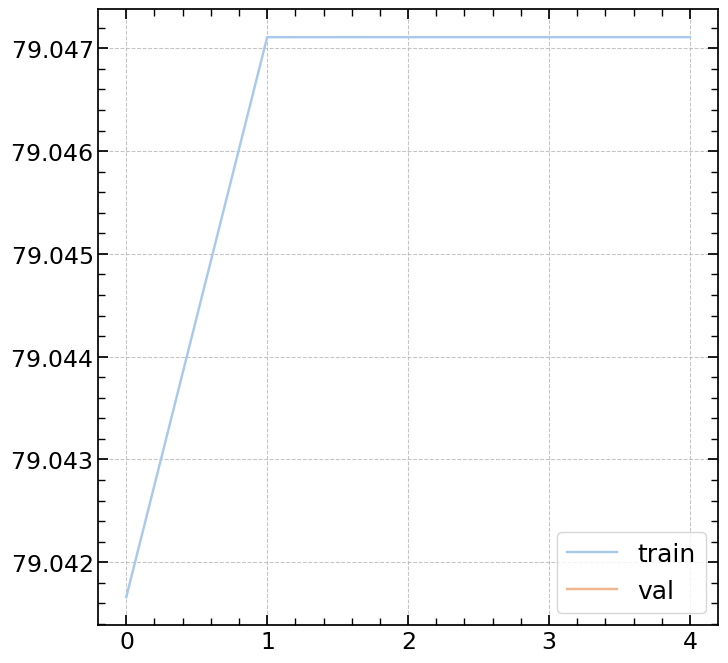

In [15]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()